https://quantopian.github.io/pyfolio/notebooks/single_stock_example/#fetch-the-daily-returns-for-a-stock
http://quantopian.github.io/empyrical/_modules/empyrical/stats.html#stability_of_timeseries


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
df_fb = yf.download('FB', start='2015-11-30', end='2017-08-23')

[*********************100%***********************]  1 of 1 completed


In [5]:
df_fb['returns'] = df_fb.Close.pct_change()
df_fb.columns = [txt.lower() for txt in df_fb.columns]
df_fb.tail()

,open,high,low,close,adj close,volume,returns
Date,,,,,,,
2017-08-16,171.250000,171.380005,169.240005,170.000000,170.000000,15779900,-0.005848
2017-08-17,169.339996,169.860001,166.850006,166.910004,166.910004,17216000,-0.018176
2017-08-18,166.839996,168.669998,166.210007,167.410004,167.410004,15093600,0.002996
2017-08-21,167.160004,168.000000,165.820007,167.779999,167.779999,11907500,0.002210
2017-08-22,168.279999,169.869995,167.149994,169.639999,169.639999,11391000,0.011086


## Simple daily cumulative returns of a stock

The simple cumulative daily return is calculated by taking the cumulative product of the daily percentage change. This calculation is represented by the following equation:

$i_{t} = (1+r_{t}) * i_{t-1}, i_{0} = 1$

$r_{t} = \frac{c_{t} - c_{t-1}}{c_{t-1}}$

Where c is the close price and t is the day.

So...

${\displaystyle CR = (\prod_{n=1}^{d} 1 + r_{t}) - 1}$

Where CR is the cumulative return of the day d from day n

https://www.oreilly.com/library/view/learning-pandas-/9781787123137/3105cd10-4928-4219-8444-25a502b46c60.xhtml

In [6]:
def cum_return(returns: pd.core.series.Series) -> np.float64:
    return np.cumprod((1 + returns))[-1] -1

In [7]:
cr = cum_return(df_fb.returns)
cr

0.6273983390842892

## Annual return

$AR = (1 + CR)^{1/n} - 1$

https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/annual-return/

The annual return is a measure of how much the investment has grown or shrunk in one year.
The annualized return is the geometric average of annual returns of each year over the investment period.

In [8]:
def annualyzed_return (returns: pd.core.series.Series) -> np.float64:
    n = (returns.index.max() - returns.index.min()).days/366
    return ((1 + cum_return(returns))**(1/n)) - 1

In [9]:
ar = annualyzed_return(df_fb.returns)
ar

0.32639582782083654

## Annualized volatility

$\sigma = \sqrt{\frac{\sum{(x_{i} - \mu)^2}}{N}} $

$AB = \sigma * \sqrt 252$

In [69]:
av = df_fb.returns.std()*np.sqrt(252)

0.24267004751522425

## Sharpe ratio

The Sharpe ratio has become the most widely used method for calculating the risk-adjusted return. Modern Portfolio Theory states that adding assets to a diversified portfolio that has low correlations can decrease portfolio risk without sacrificing return.

$SR = \frac{\mu - rf}{\sigma}$

In [74]:
df_fb.returns.mean()/df_fb.returns.std()*np.sqrt(252)

1.2818392868958208

## Maximum Drawdown

$i_{t} = (1+r_{t}) * i_{t-1}, i_{0} = 1$

$RD_{t} = \frac{i_{t}}{\max{(i_{0},i_{1}..., i_{t})}}$

$MD = \min{(RD_{0},RD_{1},...,RD_{n})} - 1 $

In [114]:
def max_drawdow(returns: pd.core.series.Series) -> np.float64:
    i = (1 + returns).cumprod()
    return np.min(i/i.expanding().max()) - 1

In [115]:
max_drawdow(df_fb.returns)

-0.1367796810812303

## Calmar ration


https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/calmar-ratio/

In [136]:
import math
# 2.38
np.absolute(annualyzed_return(df_fb.returns)/max_drawdow(df_fb.returns))


2.386288849635478

## Stability

http://quantopian.github.io/empyrical/_modules/empyrical/stats.html#stability_of_timeseries

## Kurtosis

In [141]:
df_fb.returns.dropna().kurtosis()

25.040588935741688

## Skew

In [143]:
df_fb.returns.dropna().skew()

2.1284185122818857

In [147]:
stats.kurtosis(df_fb.returns.dropna())

24.73992941679753

# Omaga ratio

https://faculty.fuqua.duke.edu/~charvey/Teaching/BA453_2006/Keating_A_universal_performance.pdf  
https://www.semanticscholar.org/paper/A-Universal-Performance-Measure-Con-Keating-Shadwick/4f72011c761f799e5ce259de8a5b0569e94c8b1c  
https://quantdare.com/omega-ratio-the-ultimate-risk-reward-ratio/  
https://www.researchgate.net/publication/228689634_Omega_as_a_performance_measure  
https://medium.com/@harishangaran/omega-performance-measure-using-python-a91752bea386  

In [6]:
def omega_ration(returns: pd.core.series.Series, threshold:float=.0) -> float:
    dailyThreshold = (threshold + 1) ** np.sqrt(1/252) - 1
    excess = returns - dailyThreshold
    positiveSum = np.sum(excess[excess > 0])
    negativeSum = np.sum(excess[excess < 0])
    omega = positiveSum/(-negativeSum)
    return omega

In [7]:
omega_ration(df_fb.returns)

1.2880400853839211

In [11]:
thresholds = np.linspace(0., 1.5, 50)
omegas = [omega_ration(df_fb.returns, threshold) for threshold in np.linspace(0., 1.5, 50)]

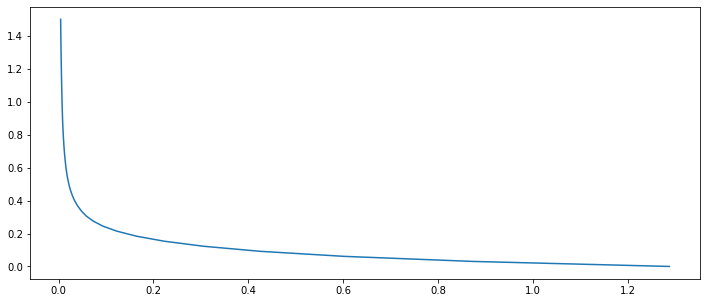

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(omegas, thresholds)
plt.show()

# Sortino ration

In [56]:
def sortino_ratio(returns: pd.core.series.Series) -> float:
    adj_returns = returns.copy()
    adj_returns[adj_returns > 0] = .0
    mean_squeres = (adj_returns**2).mean()
    dside_risk = np.sqrt(mean_squeres) 
    sortino = returns.mean()/dside_risk
    return sortino * np.sqrt(252)

In [57]:
sortino_ratio(df_fb.returns.dropna())

2.0944393687394354

In [53]:
df_fb.returns

Date
2015-11-30         NaN
2015-12-01    0.027629
2015-12-02   -0.009802
2015-12-03   -0.015933
2015-12-04    0.017245
                ...   
2017-08-16   -0.005848
2017-08-17   -0.018176
2017-08-18    0.002996
2017-08-21    0.002210
2017-08-22    0.011086
Name: returns, Length: 436, dtype: float64

# Tail_ratio (rachev ratio?)

In [58]:
def rachev_ratio(returns):
    return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))

In [63]:
rachev_ratio(df_fb.returns.dropna())

1.0214469018070695